In [1]:
import pandas as pd
import numpy as np
import pickle
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin

from interpret.glassbox import ExplainableBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli 
from snapml import BoostingMachineClassifier  
from pytorch_tabnet.tab_model import TabNetClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer 
from tab_transformer_pytorch import FTTransformer

2025-04-26 18:21:33.062479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745666493.122921   97701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745666493.131211   97701 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 18:21:33.247579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data/cleaned_data.csv')
cols_to_keep = ['age', 
                'systolic', 
                'diastolic',
                'bmi',
                'gender',
                'cholesterol', 
                'gluc',
                'smoke', 
                'alco', 
                'active',
                'cardio'
                ]

df = df[cols_to_keep]

In [3]:
X = df.drop('cardio', axis=1)
y = df['cardio']

label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

numerical_features = ['age', 'systolic', 'diastolic', 'bmi']
ordinal_features = ['cholesterol', 'gluc']
binary_features = ['gender', 'smoke', 'alco', 'active']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Catatan: ColumnTransformer dengan remainder='passthrough' akan mengubah urutan kolom.
# Fitur yang discaling akan berada di awal, kemudian sisanya.
# Untuk mendapatkan nama kolom kembali (opsional), kita bisa menyusun ulang nama kolom sebagai berikut.
passthrough_features = [col for col in X.columns if col not in numerical_features]
transformed_feature_names = numerical_features + passthrough_features

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)
print("Contoh data train setelah scaling:")
print(X_train_transformed_df.head())

Contoh data train setelah scaling:
        age  systolic  diastolic       bmi  gender  cholesterol  gluc  smoke  \
0 -0.431181 -0.448449  -0.219513  0.556238     0.0          0.0   0.0    0.0   
1  1.645896 -0.448449  -1.522162  0.164370     0.0          0.0   0.0    0.0   
2 -1.766444 -1.149304  -1.522162 -0.739102     0.0          0.0   0.0    0.0   
3 -1.469719  1.303690   1.734461  1.485835     1.0          0.0   0.0    1.0   
4 -0.134455 -0.448449  -0.219513 -0.388598     0.0          0.0   0.0    0.0   

   alco  active  
0   0.0     0.0  
1   0.0     0.0  
2   0.0     1.0  
3   1.0     1.0  
4   0.0     1.0  


In [4]:
x_train_np = np.array(X_train_transformed)
y_train_np = np.array(y_train)
x_test_np = np.array(X_test_transformed)
y_test_np = np.array(y_test)

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, categorical_indices, continuous_indices, targets):
        self.X = X
        self.categorical_indices = categorical_indices
        self.continuous_indices = continuous_indices
        self.targets = targets
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        row = self.X[idx]
        x_cont = row[self.continuous_indices].astype(np.float32)
        x_cat  = row[self.categorical_indices].astype(np.int64)
        target = np.array(self.targets[idx]).astype(np.float32)
        return x_cat, x_cont, target

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=10, lr=1e-3, batch_size=32, device=None,
                continuous_indices=None, categorical_indices=None, classes_=None):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.continuous_indices = continuous_indices
        self.categorical_indices = categorical_indices
        self.classes_ = classes_ if classes_ is not None else []
    
    def fit(self, X, y):
        if self.continuous_indices is None or self.categorical_indices is None:
            raise ValueError("continuous_indices and categorical_indices must be provided")
        train_dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, y)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.model.to(self.device)
        self.model.train()
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                targets = targets.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            print(f"[Wrapper] Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        preds = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                preds.append((probs.cpu().numpy() >= 0.5).astype(int))
        preds = np.concatenate(preds).squeeze()
        return preds

    def predict_proba(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        probas = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                probas.append(probs.cpu().numpy())
        probas = np.concatenate(probas).squeeze()
        return np.vstack([1 - probas, probas]).T

    def get_params(self, deep=True):
        return {
            "model": self.model,
            "epochs": self.epochs,
            "lr": self.lr,
            "batch_size": self.batch_size,
            "device": self.device,
            "continuous_indices": self.continuous_indices,
            "categorical_indices": self.categorical_indices,
            "classes_": self.classes_
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [6]:
def evaluate_model(
    model,
    x_train=None, y_train=None,
    x_test=None,  y_test=None,
    name='Model',
    label_mapping=None,
    cat_indices=None,
    cont_indices=None,
    device='cpu',
    # PyTorch‑specific args:
    train_loader=None,
    test_loader=None,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    comparison_models: dict = None
):
    """
    Universal evaluation for sklearn‑style or a raw PyTorch TabTransformer.
    """
    is_torch_module = isinstance(model, nn.Module) and not hasattr(model, "predict")
    
    # ===== CABANG TORCH MODULE =====
    if is_torch_module:
        # Jika user tidak kirim DataLoader, buat dari raw arrays
        if (x_train is None or y_train is None or
            x_test  is None or y_test  is None):
            raise ValueError("Provide x_train, y_train, x_test, y_test for nn.Module models")

        # Bangun DataLoader
        train_ds = TabularDataset(x_train, cat_indices, cont_indices, y_train)
        test_ds  = TabularDataset(x_test,  cat_indices, cont_indices, y_test)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

        model.to(device).train()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()

        # Loop training
        for ep in range(epochs):
            total_loss = 0
            for x_cat, x_cont, y in train_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
                optimizer.zero_grad()
                logits = model(x_cat, x_cont).squeeze(-1)
                loss = criterion(logits.unsqueeze(1), y.unsqueeze(1))
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * x_cat.size(0)
            print(f"[{name}] Epoch {ep+1}/{epochs}, Loss: {total_loss/len(train_loader.dataset):.4f}")

        model.eval()
        def _infer(loader):
            ys, ps = [], []
            with torch.no_grad():
                for x_cat, x_cont, y in loader:
                    x_cat, x_cont = x_cat.to(device), x_cont.to(device)
                    out = torch.sigmoid(model(x_cat, x_cont).squeeze(-1)).cpu().numpy()
                    ys.append(y.numpy())
                    ps.append(out)
            ys = np.concatenate(ys)
            ps = np.concatenate(ps)
            preds = (ps >= 0.5).astype(int)
            return ys, ps, preds
        
        y_tr, p_tr, pred_tr = _infer(train_loader)
        y_te, p_te, pred_te = _infer(test_loader)

    # ===== CABANG SKLEARN‑LIKE =====
    else:
        y_tr, y_te = y_train, y_test
        pred_tr = model.predict(x_train)
        pred_te = model.predict(x_test)
        p_tr    = model.predict_proba(x_train)[:, 1]
        p_te    = model.predict_proba(x_test)[:, 1]

    # ===== METRIK & OUTPUT =====
    acc_tr = accuracy_score(y_tr, pred_tr)
    auc_tr = roc_auc_score(y_tr, p_tr)
    acc_te = accuracy_score(y_te, pred_te)
    auc_te = roc_auc_score(y_te, p_te)

    print(f"\n=== {name} ===")
    print(f"Test   Acc: {acc_te:.4f}, AUC: {auc_te:.4f}")
    print(classification_report(y_te, pred_te, digits=4))
    print(f"Train  Acc: {acc_tr:.4f}, AUC: {auc_tr:.4f}")
    print(classification_report(y_tr, pred_tr, digits=4))
    print("⚠️ Overfitting suspected\n" if acc_tr>acc_te+0.05 or auc_tr>auc_te+0.05 
        else "✅ No significant overfitting\n")

    # ===== PLOT =====
    labels = list(label_mapping) if label_mapping is not None else None
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    def _plot_cm(ax, y_true, y_pred, title):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                                    display_labels=labels)
        disp.plot(ax=ax, colorbar=True, values_format='d')
        ax.set_title(f"{name} – {title}")

    def _plot_roc(ax, y_true, probs, title, auc_val):
        fpr, tpr, _ = roc_curve(y_true, probs)
        ax.plot(fpr, tpr, label=f"AUC={auc_val:.4f}", linewidth=2)
        ax.plot([0,1],[0,1],'k--', linewidth=1)
        ax.set_title(f"{name} – {title}")
        ax.legend(loc="lower right")
        ax.grid(alpha=0.3)

    _plot_cm (axes[1,0], y_te,   pred_te,  "Confusion Matrix (Test)")
    _plot_roc(axes[1,1], y_te,   p_te,     "ROC Curve (Test)",  auc_te)
    _plot_cm (axes[0,0], y_tr,   pred_tr,  "Confusion Matrix (Train)")
    _plot_roc(axes[0,1], y_tr,   p_tr,     "ROC Curve (Train)", auc_tr)

    for ax in axes.flat:
        fmt = ScalarFormatter(); fmt.set_scientific(False); fmt.set_useOffset(False)
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

    plt.tight_layout()
    plt.show()

    # ===== COMPARISON ROC =====
    if comparison_models:
        plt.figure(figsize=(8,6))
        f, t, _ = roc_curve(y_te, p_te)
        plt.plot(f, t, label=f"{name} (AUC={auc_te:.4f})", linewidth=2)
        for nm, m in comparison_models.items():
            if isinstance(m, nn.Module):
                ic = torch.from_numpy(x_test[:,cat_indices]).long().to(device)
                xc = torch.from_numpy(x_test[:,cont_indices]).float().to(device)
                with torch.no_grad():
                    pr = torch.sigmoid(m(ic,xc)).cpu().numpy().ravel()
            else:
                pr = m.predict_proba(x_test)[:,1]
            f2, t2, _ = roc_curve(y_te, pr)
            a2 = roc_auc_score(y_te, pr)
            plt.plot(f2, t2, label=f"{nm} (AUC={a2:.4f})", linewidth=2)
        plt.plot([0,1],[0,1],'k--',linewidth=1,label="Random Guess")
        plt.title("ROC Curve Comparison")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.legend(loc="lower right"); plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

    return {
        'model_name': name,
        'train_accuracy': acc_tr,
        'train_auc': auc_tr,
        'test_accuracy': acc_te,
        'test_auc': auc_te,
        'overfitting': (acc_tr>acc_te+0.05 or auc_tr>auc_te+0.05)
    }


=== LightGBM ===
Test   Acc: 0.7393, AUC: 0.8015
              precision    recall  f1-score   support

           0     0.7259    0.7784    0.7512      6321
           1     0.7552    0.6994    0.7262      6180

    accuracy                         0.7393     12501
   macro avg     0.7405    0.7389    0.7387     12501
weighted avg     0.7404    0.7393    0.7388     12501

Train  Acc: 0.7412, AUC: 0.8149
              precision    recall  f1-score   support

           0     0.7256    0.7860    0.7546     25313
           1     0.7601    0.6952    0.7262     24688

    accuracy                         0.7412     50001
   macro avg     0.7428    0.7406    0.7404     50001
weighted avg     0.7426    0.7412    0.7406     50001

✅ No significant overfitting



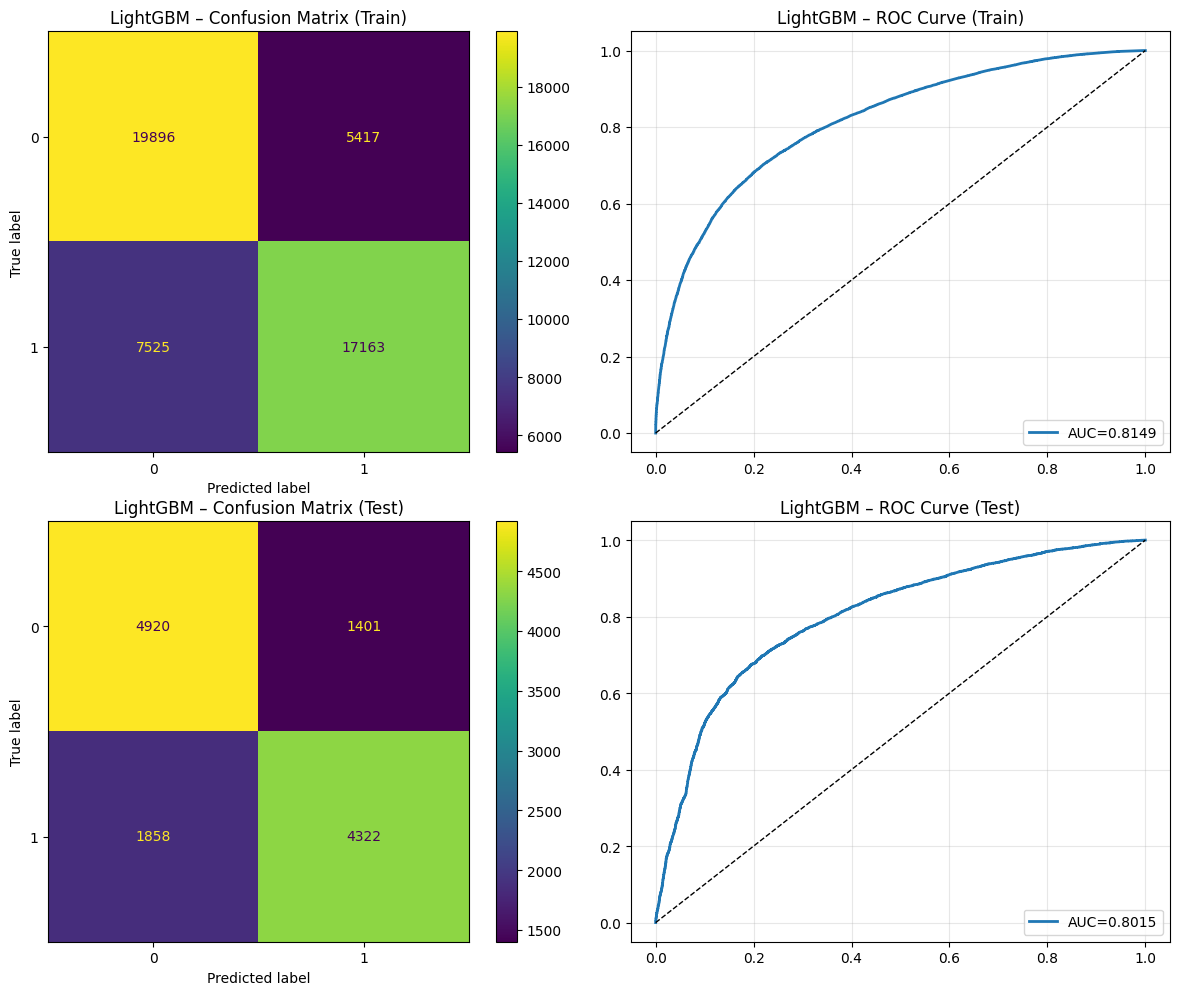

In [7]:
# best_params = {
#     'n_estimators': 233,
#     'learning_rate': 0.019519792757748358,
#     'num_leaves': 41,
#     'max_depth': 15,
#     'subsample': 0.758484089588373,
#     'colsample_bytree': 0.9592852139230149,
#     'random_state': 6580,
#     'verbose' : -1
# }

lgbm_model = LGBMClassifier(verbose=-1)

lgbm_model.fit(x_train_np, y_train_np)

lgbm_results = evaluate_model(
    model=lgbm_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="LightGBM",
)

lgbm_results;



=== CatBoost ===
Test   Acc: 0.7363, AUC: 0.8006
              precision    recall  f1-score   support

           0     0.7232    0.7750    0.7482      6321
           1     0.7517    0.6966    0.7231      6180

    accuracy                         0.7363     12501
   macro avg     0.7375    0.7358    0.7357     12501
weighted avg     0.7373    0.7363    0.7358     12501

Train  Acc: 0.7488, AUC: 0.8256
              precision    recall  f1-score   support

           0     0.7327    0.7933    0.7618     25313
           1     0.7684    0.7032    0.7344     24688

    accuracy                         0.7488     50001
   macro avg     0.7505    0.7482    0.7481     50001
weighted avg     0.7503    0.7488    0.7482     50001

✅ No significant overfitting



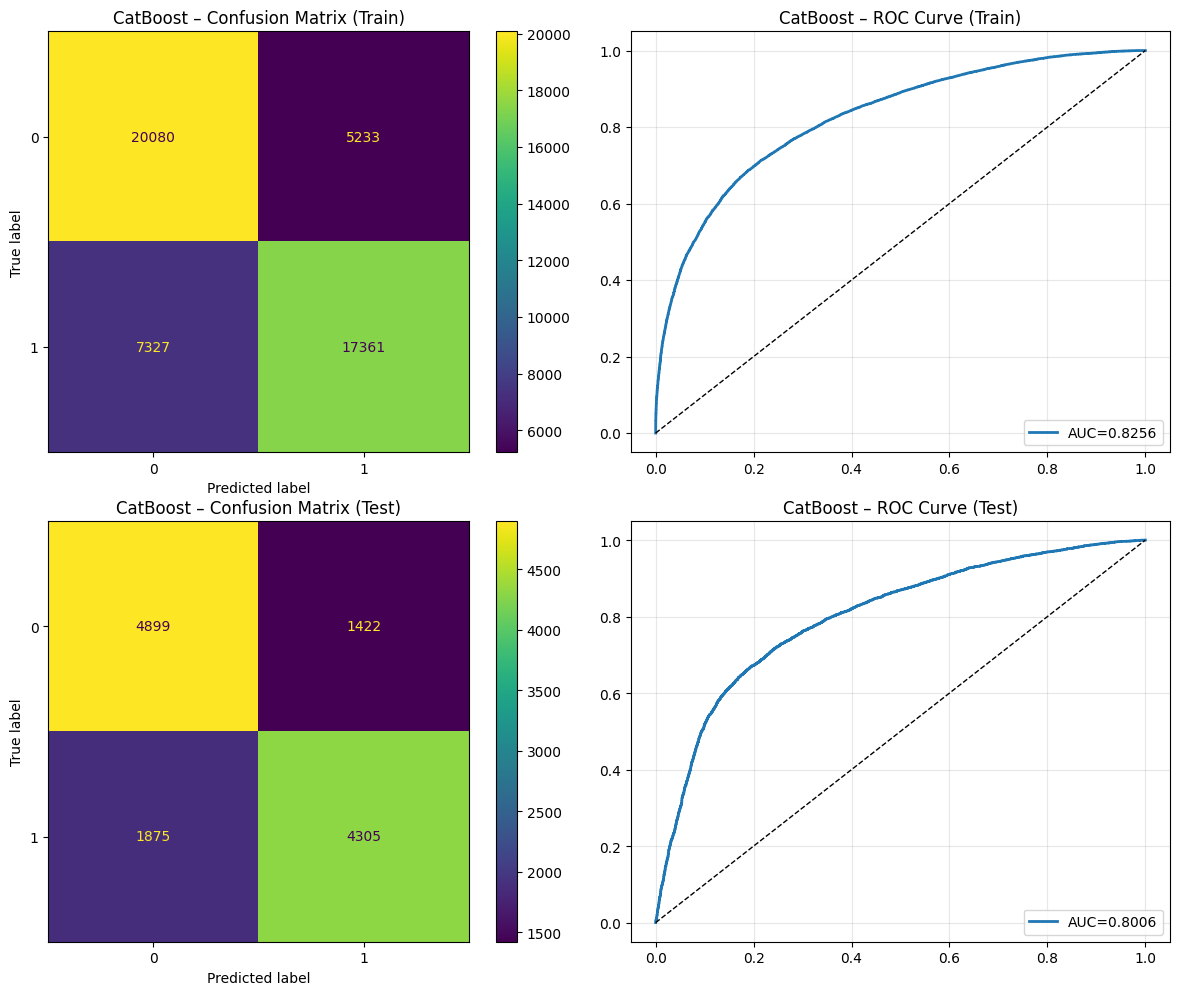

In [8]:
# best_params = {
#     'iterations': 680, 
#     'learning_rate': 0.01040286438048717, 
#     'depth': 9, 
#     'l2_leaf_reg': 0.10424693387826892, 
#     'border_count': 220, 
#     'random_strength': 0.015513247584661348, 
#     'bagging_temperature': 0.2020691195100053, 
#     'random_seed': 7801,
#     'verbose': False
#     }

catb_model = CatBoostClassifier(verbose=False)

catb_model.fit(x_train_np, y_train_np)

catb_results = evaluate_model(
    model=catb_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="CatBoost",
)

catb_results;


=== Hist Gradient Boosting ===
Test   Acc: 0.7387, AUC: 0.8019
              precision    recall  f1-score   support

           0     0.7280    0.7716    0.7492      6321
           1     0.7511    0.7052    0.7274      6180

    accuracy                         0.7387     12501
   macro avg     0.7396    0.7384    0.7383     12501
weighted avg     0.7394    0.7387    0.7384     12501

Train  Acc: 0.7382, AUC: 0.8093
              precision    recall  f1-score   support

           0     0.7254    0.7769    0.7503     25313
           1     0.7533    0.6985    0.7249     24688

    accuracy                         0.7382     50001
   macro avg     0.7394    0.7377    0.7376     50001
weighted avg     0.7392    0.7382    0.7377     50001

✅ No significant overfitting



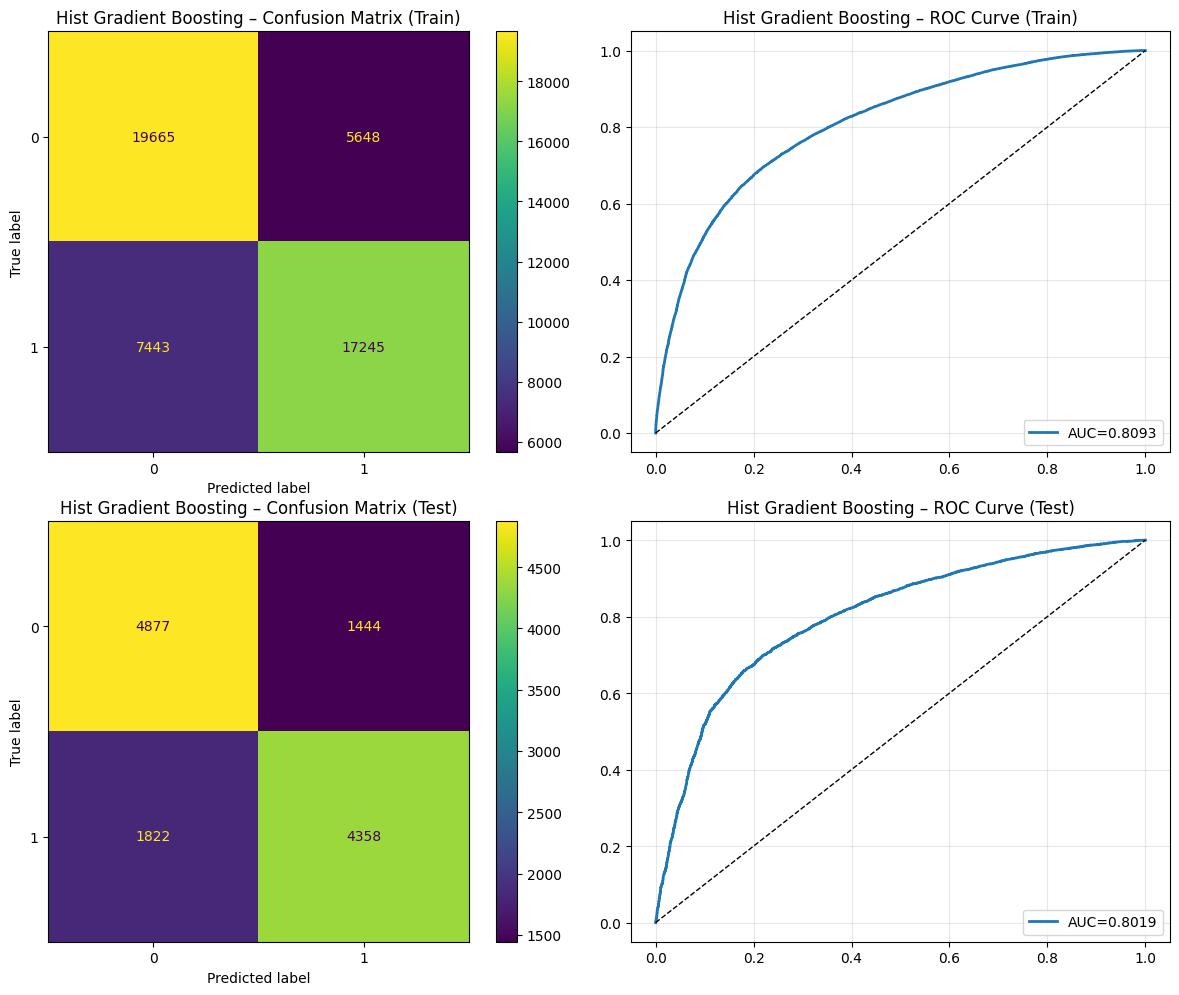

In [9]:
# best_params = {
#     'max_iter': 409, 
#     'learning_rate': 0.01947652219796748, 
#     'max_leaf_nodes': 36, 
#     'min_samples_leaf': 28, 
#     'l2_regularization': 4.313378648780895e-06, 
#     'random_state': 8404
#             }

hgrb_model =  HistGradientBoostingClassifier(random_state=42)

hgrb_model.fit(x_train_np, y_train_np)

hgrb_results = evaluate_model(
    model=hgrb_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="Hist Gradient Boosting"
)

hgrb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== AdaBoost ===
Test   Acc: 0.7334, AUC: 0.7963
              precision    recall  f1-score   support

           0     0.7047    0.8136    0.7553      6321
           1     0.7736    0.6513    0.7072      6180

    accuracy                         0.7334     12501
   macro avg     0.7392    0.7325    0.7312     12501
weighted avg     0.7388    0.7334    0.7315     12501

Train  Acc: 0.7235, AUC: 0.7901
              precision    recall  f1-score   support

           0     0.6955    0.8071    0.7472     25313
           1     0.7633    0.6377    0.6949     24688

    accuracy                         0.7235     50001
   macro avg     0.7294    0.7224    0.7210     50001
weighted avg     0.7290    0.7235    0.7213     50001

✅ No significant overfitting



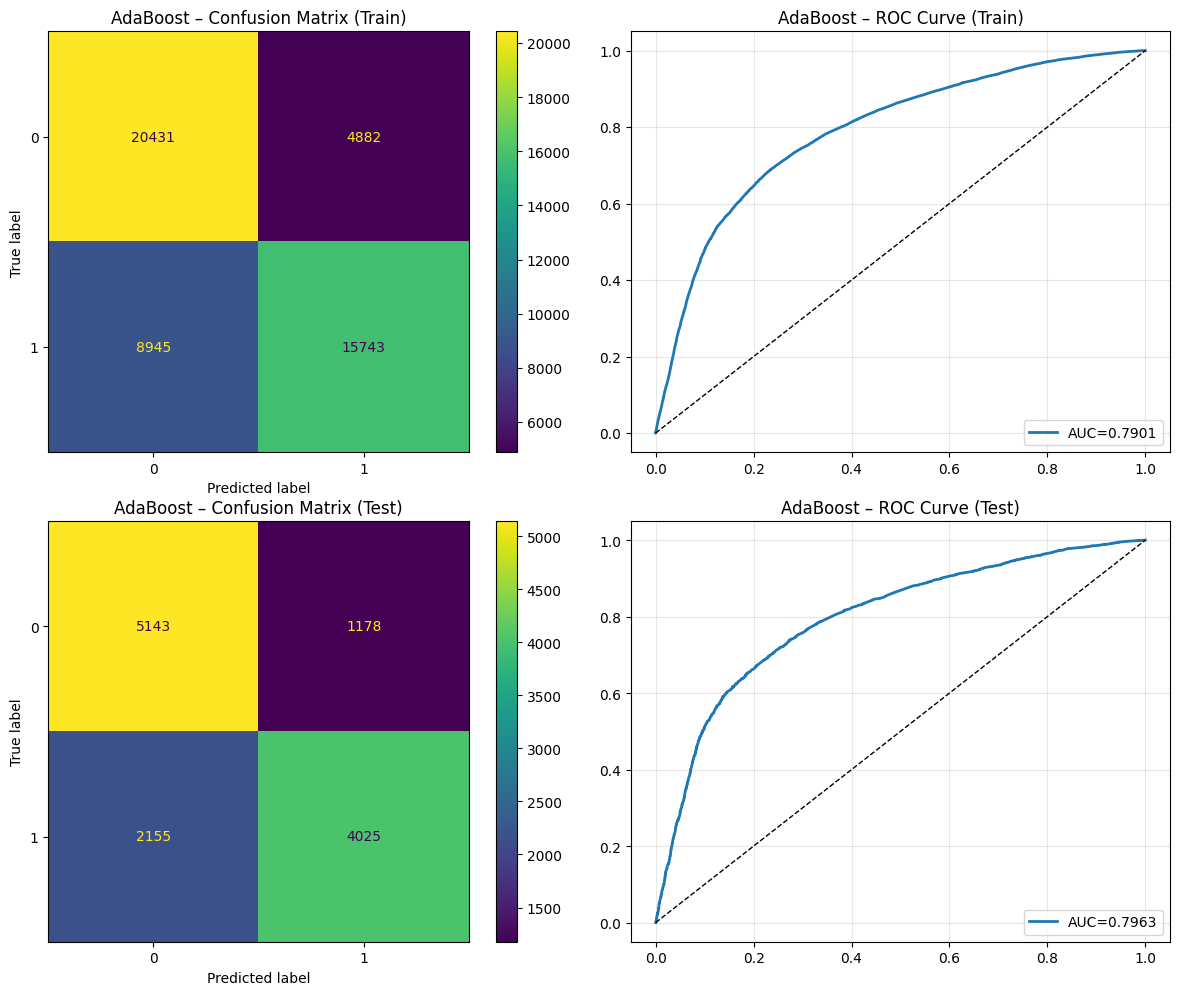

In [10]:
# best_params = {'n_estimators': 478, 'learning_rate': 0.17278746878628695, 'random_state': 5660}

adb_model = AdaBoostClassifier()

adb_model.fit(x_train_np, y_train_np)

adb_results = evaluate_model(
    model=adb_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="AdaBoost"
)

adb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)



=== TabNet ===
Test   Acc: 0.7374, AUC: 0.7981
              precision    recall  f1-score   support

           0     0.7203    0.7856    0.7516      6321
           1     0.7583    0.6880    0.7215      6180

    accuracy                         0.7374     12501
   macro avg     0.7393    0.7368    0.7365     12501
weighted avg     0.7391    0.7374    0.7367     12501

Train  Acc: 0.7319, AUC: 0.7987
              precision    recall  f1-score   support

           0     0.7132    0.7867    0.7482     25313
           1     0.7555    0.6757    0.7134     24688

    accuracy                         0.7319     50001
   macro avg     0.7344    0.7312    0.7308     50001
weighted avg     0.7341    0.7319    0.7310     50001

✅ No significant overfitting



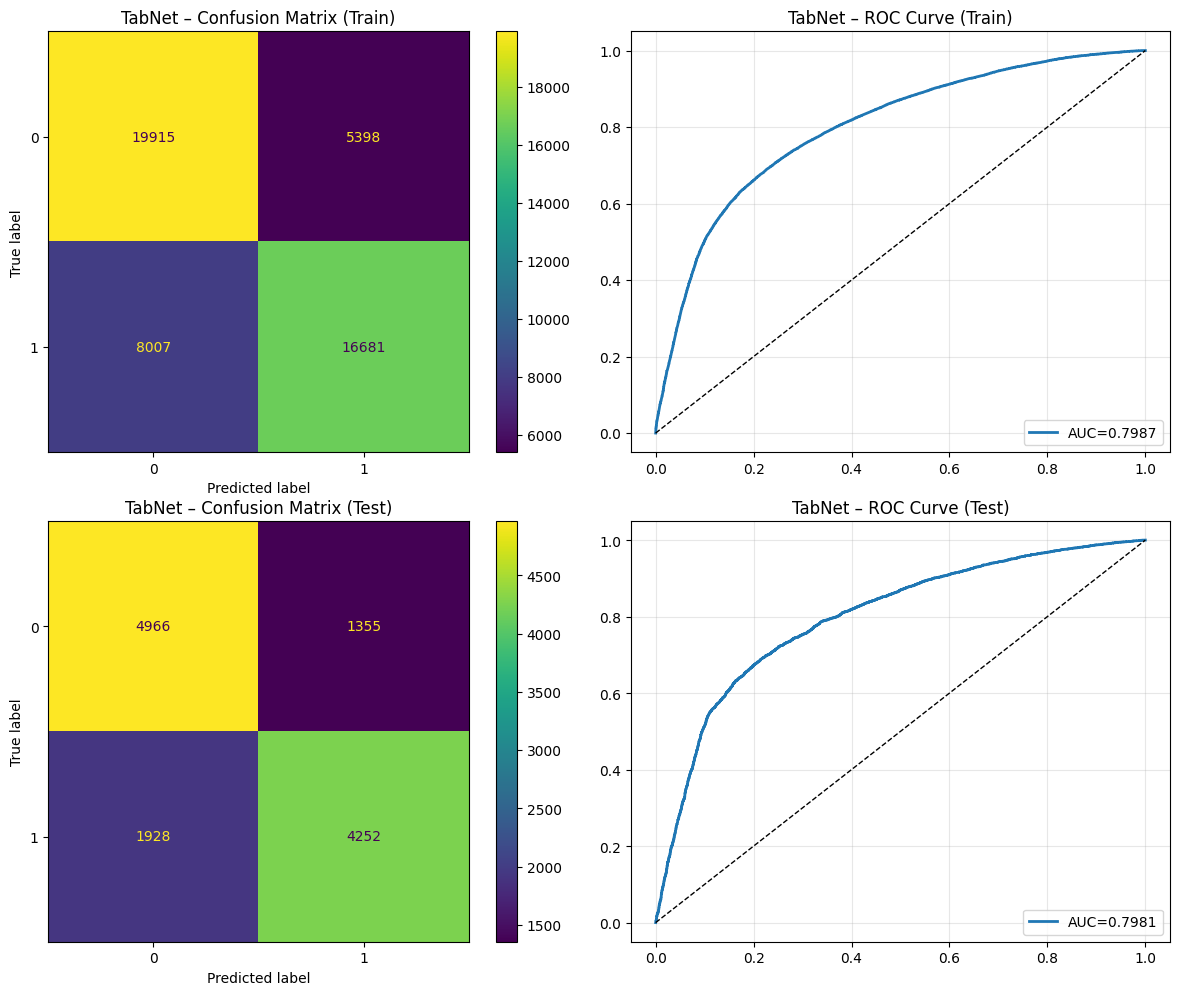

In [11]:
tabnet_model = TabNetClassifier(verbose=0)

tabnet_model.fit(x_train_np, y_train_np)

tabnet_results = evaluate_model(
    model=tabnet_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="TabNet"
)

tabnet_results;

In [12]:
continuous_indices = list(range(len(numerical_features)))  
categorical_indices = list(range(len(numerical_features), len(transformed_feature_names)))  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[TabTransformer] Epoch 1/10, Loss: 0.6540
[TabTransformer] Epoch 2/10, Loss: 0.6419
[TabTransformer] Epoch 3/10, Loss: 0.6403
[TabTransformer] Epoch 4/10, Loss: 0.6396
[TabTransformer] Epoch 5/10, Loss: 0.6382
[TabTransformer] Epoch 6/10, Loss: 0.6380
[TabTransformer] Epoch 7/10, Loss: 0.6375
[TabTransformer] Epoch 8/10, Loss: 0.6366
[TabTransformer] Epoch 9/10, Loss: 0.6362
[TabTransformer] Epoch 10/10, Loss: 0.6357

=== TabTransformer ===
Test   Acc: 0.6547, AUC: 0.6949
              precision    recall  f1-score   support

         0.0     0.6271    0.7820    0.6961      6321
         1.0     0.7017    0.5244    0.6002      6180

    accuracy                         0.6547     12501
   macro avg     0.6644    0.6532    0.6481     12501
weighted avg     0.6640    0.6547    0.6487     12501

Train  Acc: 0.6472, AUC: 0.6879
              precision    recall  f1-score   support

         0.0     0.6195    0.7856    0.6928     25313
         1.0     0.6969    0.5053    0.5859     24688



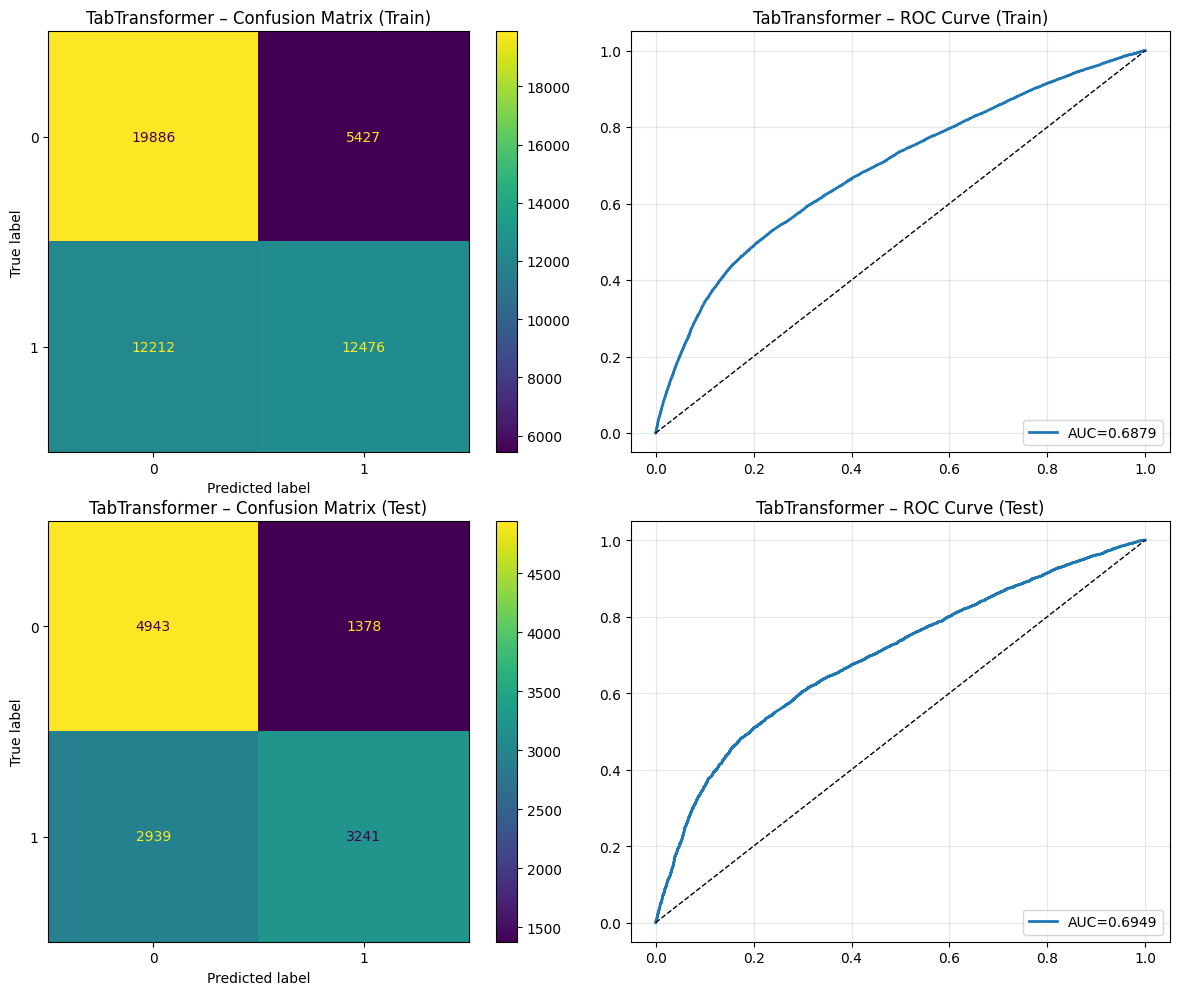

In [13]:
tabtf_model = TabTransformer(
    categories = (3, 3, 2, 2, 2, 2), 
    num_continuous = len(continuous_indices),
    dim = 32,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1,
    mlp_hidden_mults = (4, 2),
    mlp_act = nn.ReLU(),
    continuous_mean_std = None
).to(device)

tabtf_wrapper = PyTorchClassifier(
    model=tabtf_model,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    categorical_indices=list(range(len(numerical_features), len(transformed_feature_names))),
    continuous_indices=list(range(len(numerical_features)))
)

tabtf_results = evaluate_model(
    model=tabtf_model,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='TabTransformer',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices,
)


tabtf_results;

[FT-Transformer] Epoch 1/10, Loss: 0.5593
[FT-Transformer] Epoch 2/10, Loss: 0.5536
[FT-Transformer] Epoch 3/10, Loss: 0.5522
[FT-Transformer] Epoch 4/10, Loss: 0.5516
[FT-Transformer] Epoch 5/10, Loss: 0.5502
[FT-Transformer] Epoch 6/10, Loss: 0.5500
[FT-Transformer] Epoch 7/10, Loss: 0.5494
[FT-Transformer] Epoch 8/10, Loss: 0.5490
[FT-Transformer] Epoch 9/10, Loss: 0.5492
[FT-Transformer] Epoch 10/10, Loss: 0.5487

=== FT-Transformer ===
Test   Acc: 0.7381, AUC: 0.8016
              precision    recall  f1-score   support

         0.0     0.7050    0.8290    0.7620      6321
         1.0     0.7867    0.6451    0.7089      6180

    accuracy                         0.7381     12501
   macro avg     0.7458    0.7371    0.7354     12501
weighted avg     0.7454    0.7381    0.7357     12501

Train  Acc: 0.7286, AUC: 0.7970
              precision    recall  f1-score   support

         0.0     0.6961    0.8236    0.7545     25313
         1.0     0.7773    0.6312    0.6967     24688



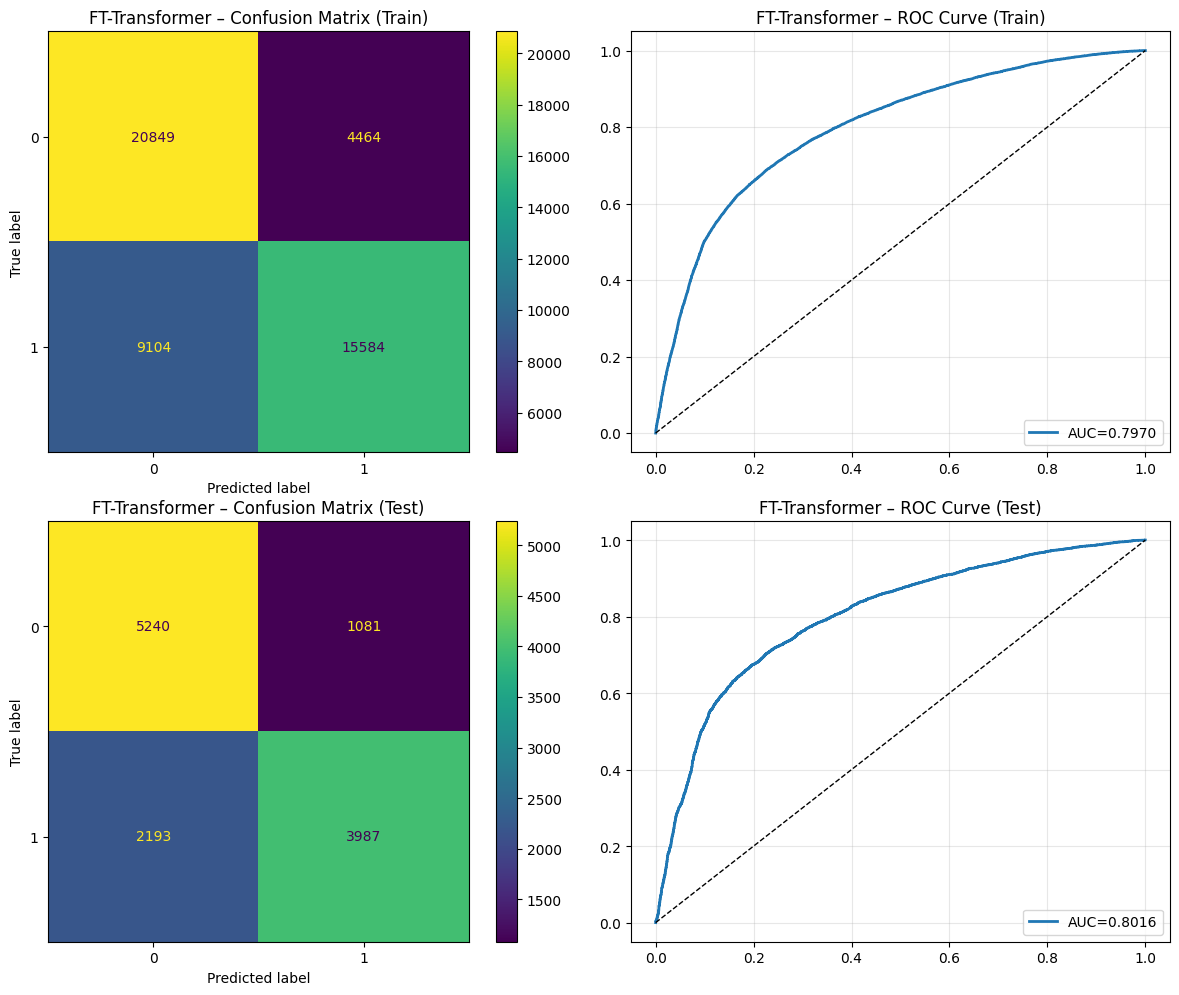

In [14]:
fttf_model = FTTransformer(
    categories = (3, 3, 2, 2, 2, 2), 
    num_continuous = len(continuous_indices),
    dim = 32,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1
).to(device)

fttf_wrapper = PyTorchClassifier(
    model=fttf_model,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    categorical_indices=list(range(len(numerical_features), len(transformed_feature_names))),
    continuous_indices=list(range(len(numerical_features)))
)

ftttf_results = evaluate_model(
    model=fttf_model,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='FT-Transformer',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices,
)


ftttf_results;


In [15]:
base_models_ml = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model)
]

base_models_dl = [
    ('tabnet', tabnet_model),
    ('tabtf', tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

base_models_el = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model),
    ('tabnet', tabnet_model),
    ('tabtf',tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

In [16]:
meta_model = adb_model

In [17]:
stacking_model_ml = StackingClassifier(estimators=base_models_ml,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_dl = StackingClassifier(estimators=base_models_dl,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_el = StackingClassifier(estimators=base_models_el,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

In [18]:
stacking_model_ml.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7e55c508cf10>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


=== Stacking ML Model ===
Test   Acc: 0.7363, AUC: 0.8002
              precision    recall  f1-score   support

           0     0.7189    0.7858    0.7509      6321
           1     0.7579    0.6858    0.7200      6180

    accuracy                         0.7363     12501
   macro avg     0.7384    0.7358    0.7354     12501
weighted avg     0.7382    0.7363    0.7356     12501

Train  Acc: 0.7437, AUC: 0.8128
              precision    recall  f1-score   support

           0     0.7241    0.7976    0.7591     25313
           1     0.7684    0.6885    0.7262     24688

    accuracy                         0.7437     50001
   macro avg     0.7463    0.7430    0.7427     50001
weighted avg     0.7460    0.7437    0.7429     50001

✅ No significant overfitting



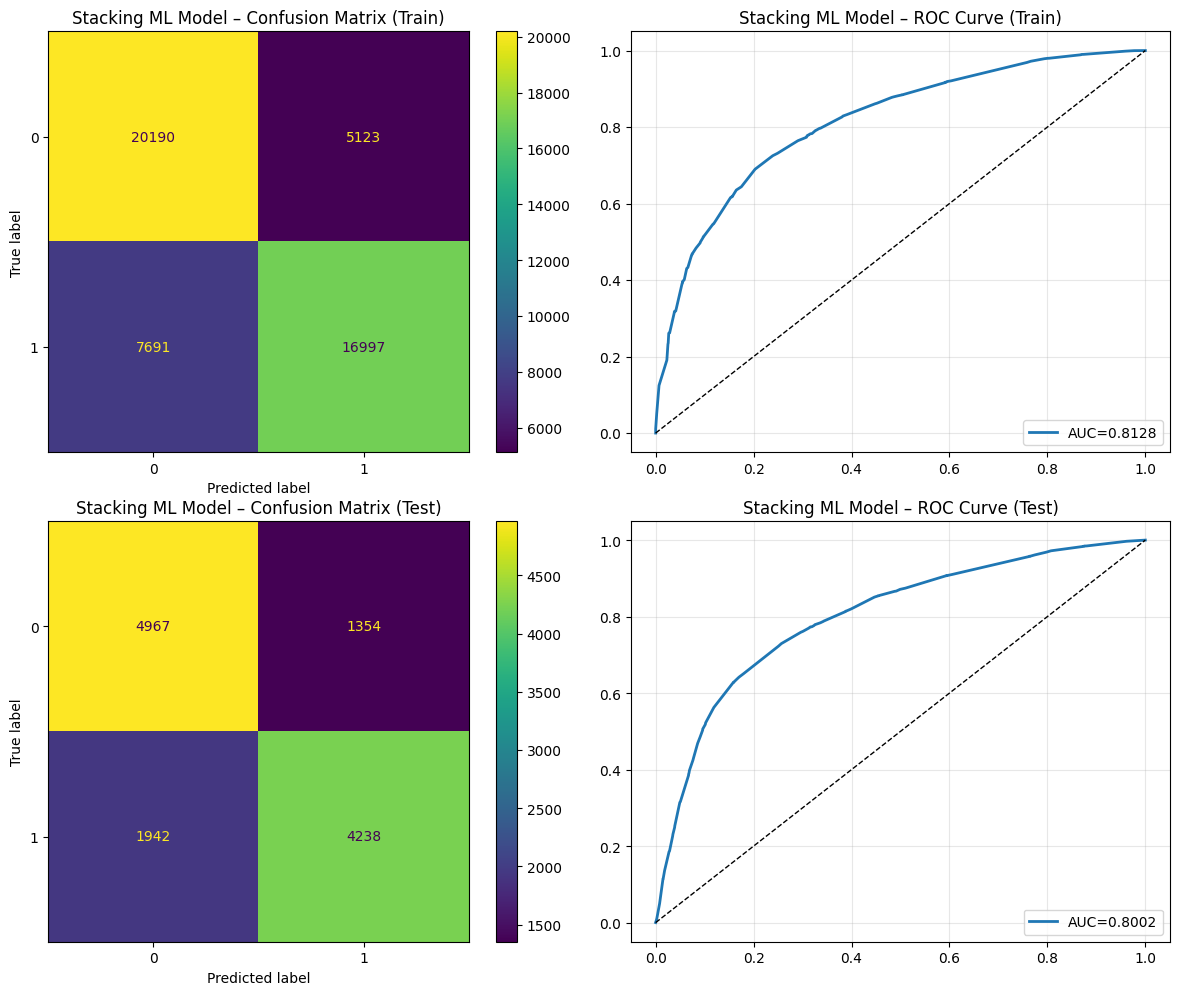

In [19]:
stacking_model_ml_results = evaluate_model(
    model=stacking_model_ml,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='Stacking ML Model',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices
)

stacking_model_ml_results;

In [20]:
stacking_model_dl.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.6343
[Wrapper] Epoch 2/10, Loss: 0.6334
[Wrapper] Epoch 3/10, Loss: 0.6311
[Wrapper] Epoch 4/10, Loss: 0.6317
[Wrapper] Epoch 5/10, Loss: 0.6300
[Wrapper] Epoch 6/10, Loss: 0.6266
[Wrapper] Epoch 7/10, Loss: 0.6264
[Wrapper] Epoch 8/10, Loss: 0.6240
[Wrapper] Epoch 9/10, Loss: 0.6238
[Wrapper] Epoch 10/10, Loss: 0.6221
[Wrapper] Epoch 1/10, Loss: 0.5486
[Wrapper] Epoch 2/10, Loss: 0.5483
[Wrapper] Epoch 3/10, Loss: 0.5480
[Wrapper] Epoch 4/10, Loss: 0.5482
[Wrapper] Epoch 5/10, Loss: 0.5478
[Wrapper] Epoch 6/10, Loss: 0.5475
[Wrapper] Epoch 7/10, Loss: 0.5470
[Wrapper] Epoch 8/10, Loss: 0.5471
[Wrapper] Epoch 9/10, Loss: 0.5470
[Wrapper] Epoch 10/10, Loss: 0.5464


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.6345
[Wrapper] Epoch 2/10, Loss: 0.6339
[Wrapper] Epoch 3/10, Loss: 0.6320
[Wrapper] Epoch 4/10, Loss: 0.6312
[Wrapper] Epoch 5/10, Loss: 0.6296
[Wrapper] Epoch 6/10, Loss: 0.6279
[Wrapper] Epoch 7/10, Loss: 0.6266
[Wrapper] Epoch 8/10, Loss: 0.6257
[Wrapper] Epoch 9/10, Loss: 0.6254
[Wrapper] Epoch 10/10, Loss: 0.6227
[Wrapper] Epoch 1/10, Loss: 0.6357
[Wrapper] Epoch 2/10, Loss: 0.6344
[Wrapper] Epoch 3/10, Loss: 0.6331
[Wrapper] Epoch 4/10, Loss: 0.6320
[Wrapper] Epoch 5/10, Loss: 0.6296
[Wrapper] Epoch 6/10, Loss: 0.6297
[Wrapper] Epoch 7/10, Loss: 0.6265
[Wrapper] Epoch 8/10, Loss: 0.6268
[Wrapper] Epoch 9/10, Loss: 0.6243
[Wrapper] Epoch 10/10, Loss: 0.6232
[Wrapper] Epoch 1/10, Loss: 0.6347
[Wrapper] Epoch 2/10, Loss: 0.6340
[Wrapper] Epoch 3/10, Loss: 0.6330
[Wrapper] Epoch 4/10, Loss: 0.6314
[Wrapper] Epoch 5/10, Loss: 0.6310
[Wrapper] Epoch 6/10, Loss: 0.6314
[Wrapper] Epoch 7/10, Loss: 0.6296
[Wrapper] Epoch 8/10, Loss: 0.6271
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=0,
                                                 clip_value=1,
                                                 verbose=0,
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


=== Stacking DL Model ===
Test   Acc: 0.7376, AUC: 0.8010
              precision    recall  f1-score   support

           0     0.7172    0.7942    0.7538      6321
           1     0.7635    0.6798    0.7192      6180

    accuracy                         0.7376     12501
   macro avg     0.7404    0.7370    0.7365     12501
weighted avg     0.7401    0.7376    0.7367     12501

Train  Acc: 0.7323, AUC: 0.7980
              precision    recall  f1-score   support

           0     0.7108    0.7944    0.7503     25313
           1     0.7603    0.6685    0.7115     24688

    accuracy                         0.7323     50001
   macro avg     0.7355    0.7315    0.7309     50001
weighted avg     0.7352    0.7323    0.7311     50001

✅ No significant overfitting



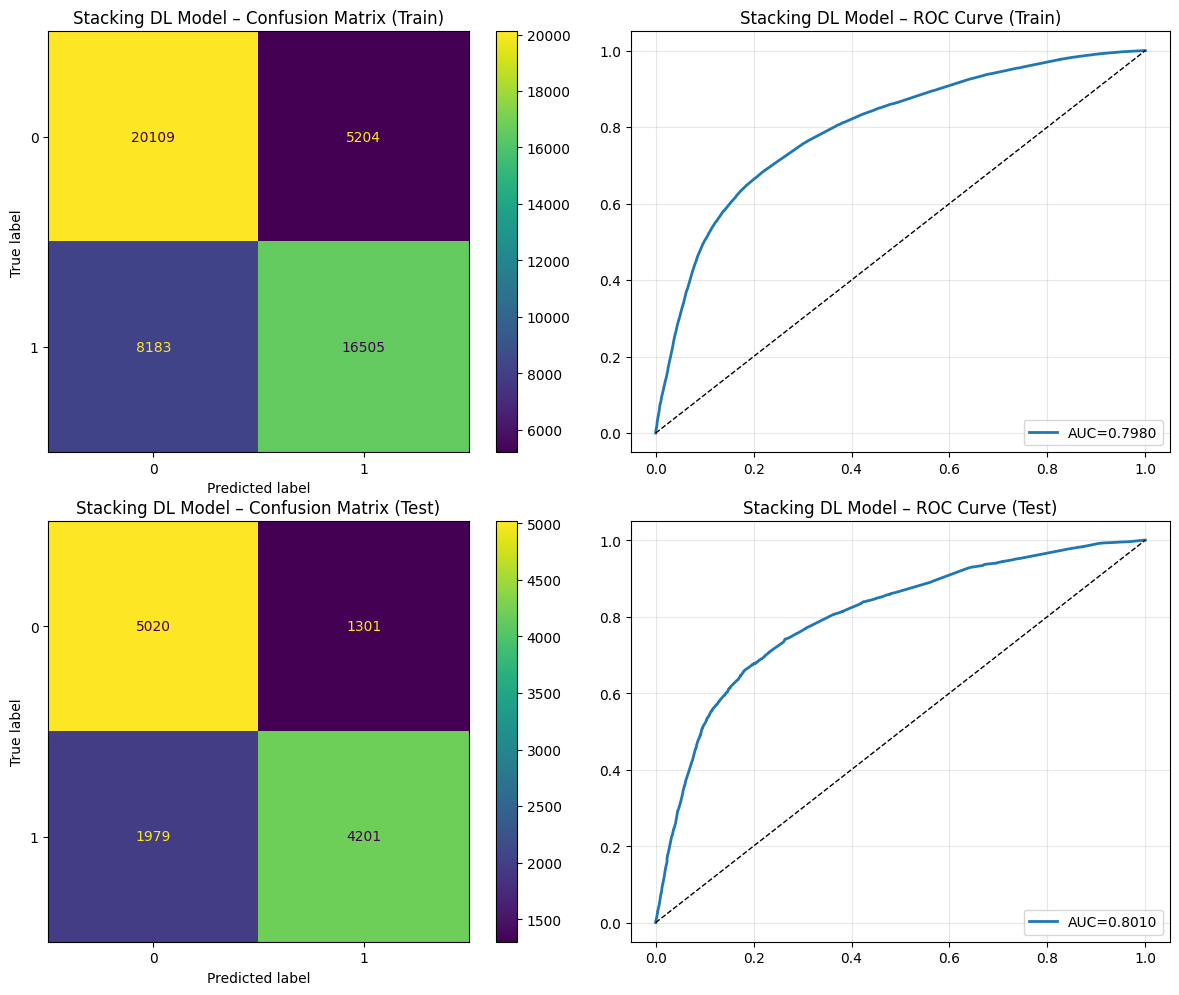

In [21]:
stacking_model_dl_results = evaluate_model(
    model=stacking_model_dl,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='Stacking DL Model',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices
)


stacking_model_dl_results;


In [22]:
stacking_model_el.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.6343
[Wrapper] Epoch 2/10, Loss: 0.6334
[Wrapper] Epoch 3/10, Loss: 0.6311
[Wrapper] Epoch 4/10, Loss: 0.6317
[Wrapper] Epoch 5/10, Loss: 0.6300
[Wrapper] Epoch 6/10, Loss: 0.6266
[Wrapper] Epoch 7/10, Loss: 0.6264
[Wrapper] Epoch 8/10, Loss: 0.6240
[Wrapper] Epoch 9/10, Loss: 0.6238
[Wrapper] Epoch 10/10, Loss: 0.6221
[Wrapper] Epoch 1/10, Loss: 0.5486
[Wrapper] Epoch 2/10, Loss: 0.5483
[Wrapper] Epoch 3/10, Loss: 0.5480
[Wrapper] Epoch 4/10, Loss: 0.5482
[Wrapper] Epoch 5/10, Loss: 0.5478
[Wrapper] Epoch 6/10, Loss: 0.5475
[Wrapper] Epoch 7/10, Loss: 0.5470
[Wrapper] Epoch 8/10, Loss: 0.5471
[Wrapper] Epoch 9/10, Loss: 0.5470
[Wrapper] Epoch 10/10, Loss: 0.5464


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.6345
[Wrapper] Epoch 2/10, Loss: 0.6339
[Wrapper] Epoch 3/10, Loss: 0.6320
[Wrapper] Epoch 4/10, Loss: 0.6312
[Wrapper] Epoch 5/10, Loss: 0.6296
[Wrapper] Epoch 6/10, Loss: 0.6279
[Wrapper] Epoch 7/10, Loss: 0.6266
[Wrapper] Epoch 8/10, Loss: 0.6257
[Wrapper] Epoch 9/10, Loss: 0.6254
[Wrapper] Epoch 10/10, Loss: 0.6227
[Wrapper] Epoch 1/10, Loss: 0.6357
[Wrapper] Epoch 2/10, Loss: 0.6344
[Wrapper] Epoch 3/10, Loss: 0.6331
[Wrapper] Epoch 4/10, Loss: 0.6320
[Wrapper] Epoch 5/10, Loss: 0.6296
[Wrapper] Epoch 6/10, Loss: 0.6297
[Wrapper] Epoch 7/10, Loss: 0.6265
[Wrapper] Epoch 8/10, Loss: 0.6268
[Wrapper] Epoch 9/10, Loss: 0.6243
[Wrapper] Epoch 10/10, Loss: 0.6232
[Wrapper] Epoch 1/10, Loss: 0.6347
[Wrapper] Epoch 2/10, Loss: 0.6340
[Wrapper] Epoch 3/10, Loss: 0.6330
[Wrapper] Epoch 4/10, Loss: 0.6314
[Wrapper] Epoch 5/10, Loss: 0.6310
[Wrapper] Epoch 6/10, Loss: 0.6314
[Wrapper] Epoch 7/10, Loss: 0.6296
[Wrapper] Epoch 8/10, Loss: 0.6271
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7e55c508cf10>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42)),
                               ('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lam...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


=== Stacking Hybird Ensemble Model ===
Test   Acc: 0.7384, AUC: 0.8003
              precision    recall  f1-score   support

           0     0.7156    0.8011    0.7559      6321
           1     0.7683    0.6743    0.7182      6180

    accuracy                         0.7384     12501
   macro avg     0.7419    0.7377    0.7371     12501
weighted avg     0.7416    0.7384    0.7373     12501

Train  Acc: 0.7335, AUC: 0.8044
              precision    recall  f1-score   support

           0     0.7092    0.8027    0.7531     25313
           1     0.7661    0.6624    0.7105     24688

    accuracy                         0.7335     50001
   macro avg     0.7376    0.7326    0.7318     50001
weighted avg     0.7373    0.7335    0.7320     50001

✅ No significant overfitting



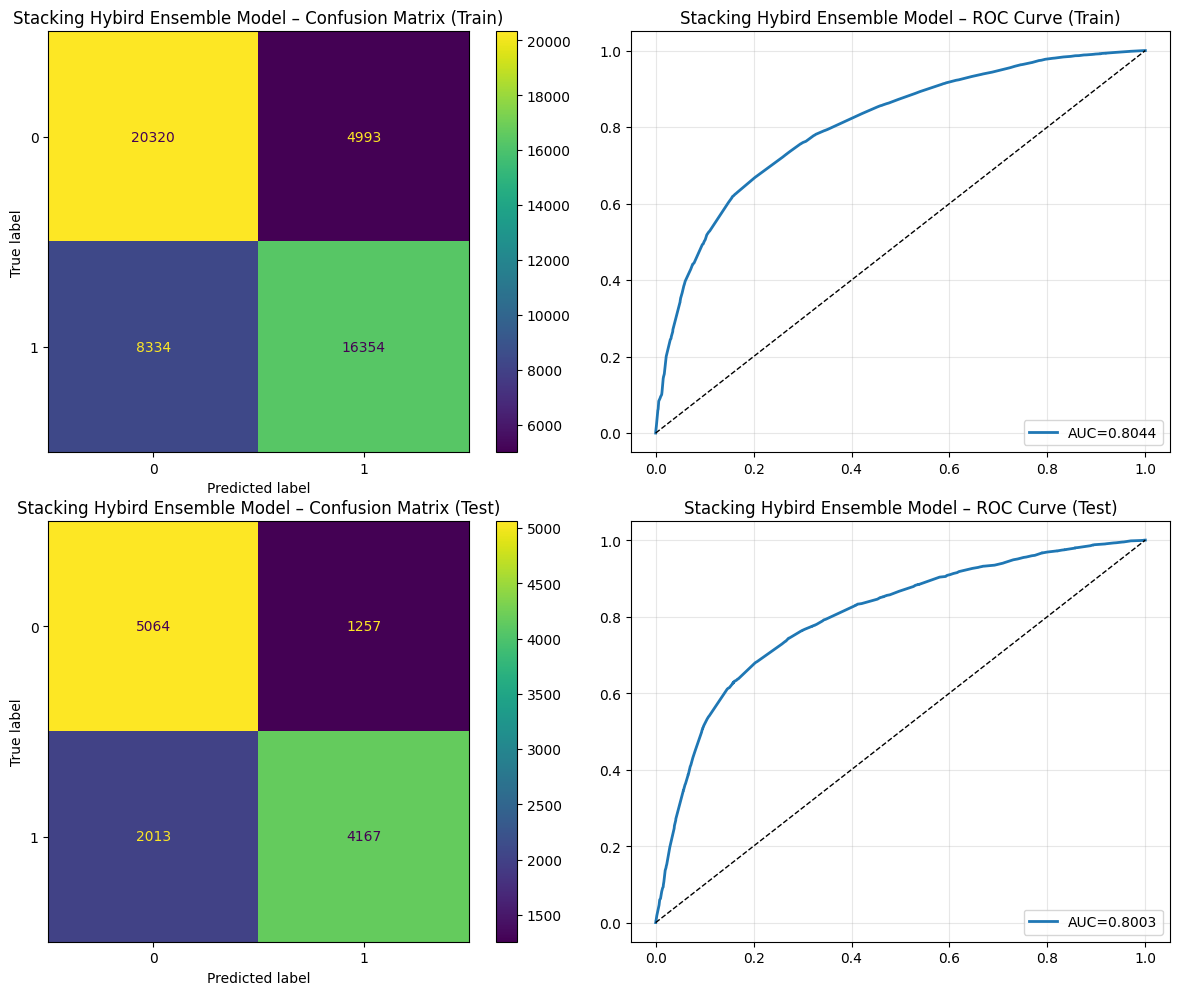

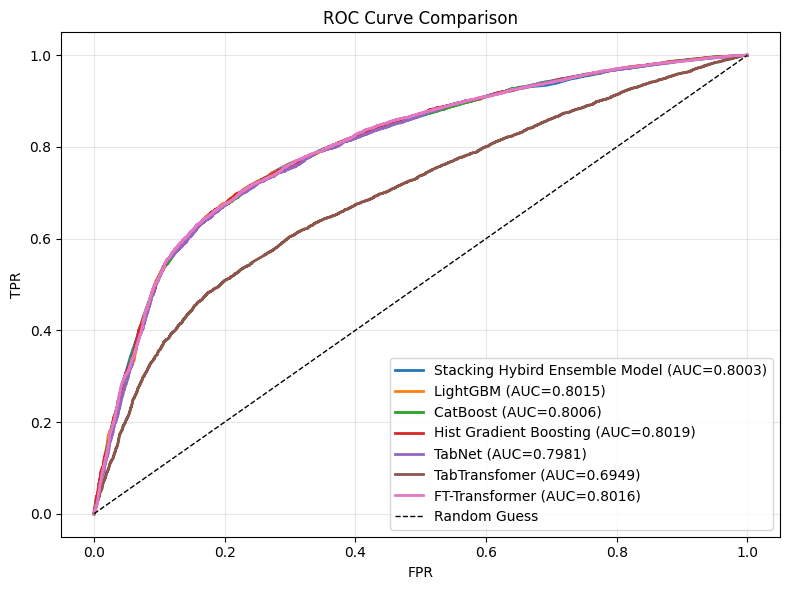

In [23]:
stacking_model_el_results = evaluate_model(
    model=stacking_model_el,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='Stacking Hybird Ensemble Model',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices,
    comparison_models={'LightGBM': lgbm_model, 'CatBoost': catb_model, 'Hist Gradient Boosting': hgrb_model, 
                    'TabNet':tabnet_model, 'TabTransfomer': tabtf_model, 'FT-Transformer': fttf_model}
)


stacking_model_el_results;


=== Stacking Hybird Ensemble Model ===
Test   Acc: 0.7384, AUC: 0.8003
              precision    recall  f1-score   support

           0     0.7156    0.8011    0.7559      6321
           1     0.7683    0.6743    0.7182      6180

    accuracy                         0.7384     12501
   macro avg     0.7419    0.7377    0.7371     12501
weighted avg     0.7416    0.7384    0.7373     12501

Train  Acc: 0.7335, AUC: 0.8044
              precision    recall  f1-score   support

           0     0.7092    0.8027    0.7531     25313
           1     0.7661    0.6624    0.7105     24688

    accuracy                         0.7335     50001
   macro avg     0.7376    0.7326    0.7318     50001
weighted avg     0.7373    0.7335    0.7320     50001

✅ No significant overfitting



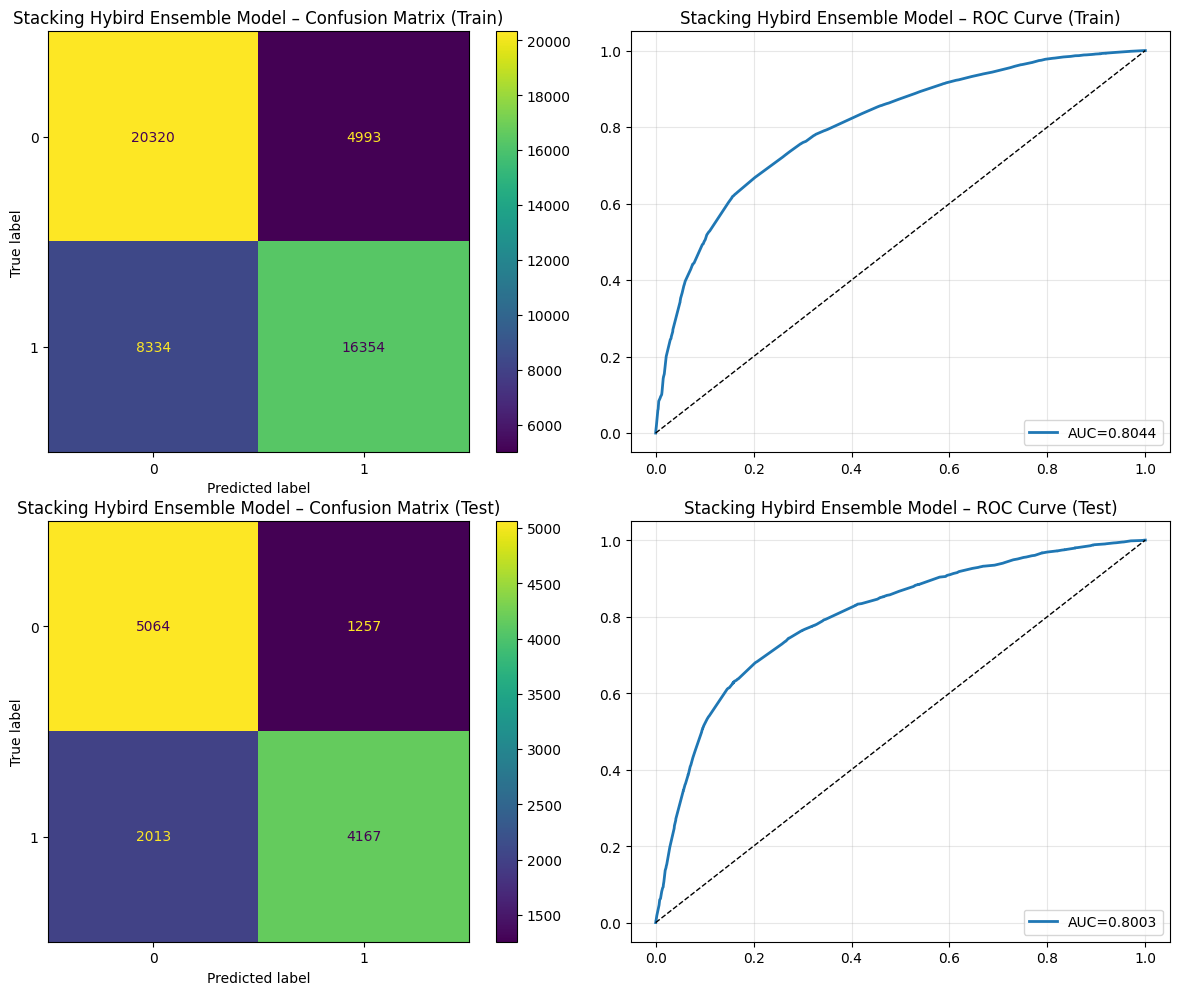

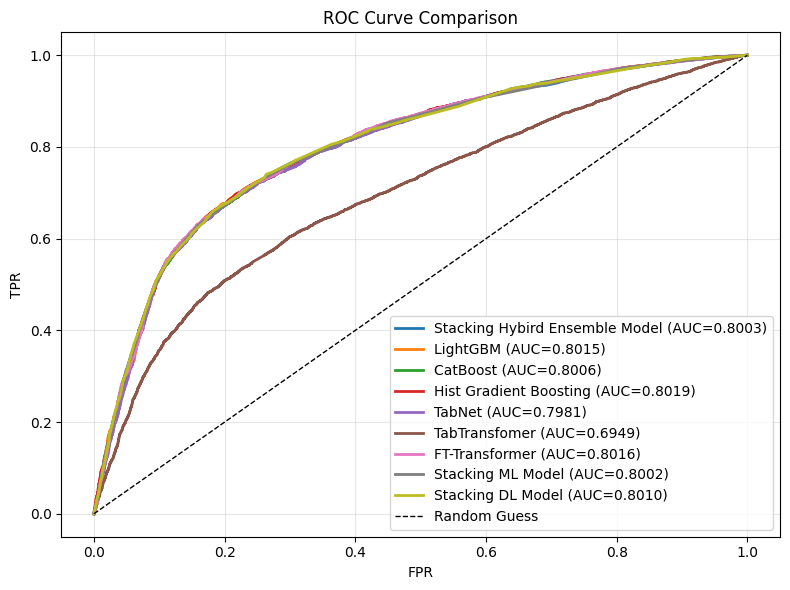

In [24]:
stacking_model_el_results = evaluate_model(
    model=stacking_model_el,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='Stacking Hybird Ensemble Model',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices,
    comparison_models={'LightGBM': lgbm_model, 'CatBoost': catb_model, 'Hist Gradient Boosting': hgrb_model, 
                    'TabNet':tabnet_model, 'TabTransfomer': tabtf_model, 'FT-Transformer': fttf_model, 
                    'Stacking ML Model': stacking_model_ml, 'Stacking DL Model':stacking_model_dl}
)


stacking_model_el_results;

In [25]:
# import numpy as np
# from scipy.stats import pearsonr

# # Misal, prediksi probabilitas dari base model disimpan dalam dictionary
# # Prediksi base model harus berupa array 1 dimensi (misalnya, probabilitas kelas positif)
# preds_lgbm = lgbm_model.predict_proba(x_test_np)[:, 1]
# preds_cat = catb_model.predict_proba(x_test_np)[:, 1]
# preds_hgrb = hgrb_model.predict_proba(x_test_np)[:, 1]
# preds_tabnet = tabnet_model.predict_proba(x_test_np)[:, 1]

# # Menyimpan semua prediksi di dalam array
# all_preds = np.vstack([preds_lgbm, preds_cat, preds_hgrb, preds_tabnet])

# # Menghitung korelasi antar model
# n_models = all_preds.shape[0]
# for i in range(n_models):
#     for j in range(i+1, n_models):
#         corr_coef, _ = pearsonr(all_preds[i], all_preds[j])
#         print(f"Korelasi antara model {i} dan model {j}: {corr_coef:.3f}")


In [26]:
# numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ],
#     remainder='passthrough' 
# )

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', stacking_model)
# ])

# pipeline.fit(X_train, y_train)

# with open("pkl/ml_ensemble_model.pkl", "wb") as f:
#     pickle.dump(pipeline, f)

# print("Pipeline telah disimpan dalam file 'ml_ensemble_model_v2.pkl'.")

In [27]:
# with open('pkl/ml_ensemble_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Lakukan prediksi menggunakan CPU
# y_pred = loaded_model.predict(X_test)

# # Menghitung dan menampilkan accuracy score
# acc = accuracy_score(y_test, y_pred)
# print("Akurasi model:", acc)

In [28]:
# data_new = {
#     'age':       [30, 35, 40, 45, 50, 60, 65, 70, 55, 68],   
#     'height':    [175, 180, 170, 165, 160, 158, 155, 150, 165, 160], 
#     'weight':    [68, 75, 72, 80, 85, 90, 95, 100, 78, 82], 
#     'systolic':  [110, 115, 120, 125, 130, 140, 150, 160, 115, 135],  
#     'diastolic': [70, 75, 80, 85, 90, 95, 100, 105, 75, 88],         
#     'gender':       [0, 0, 1, 0, 1, 1, 1, 1, 0, 1], # gender: 0 untuk nilai asli 1, 1 untuk nilai asli 2
#     'cholesterol':  [0, 0, 1, 1, 2, 2, 2, 2, 0, 2], # cholesterol: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'gluc':         [0, 0, 1, 1, 1, 2, 2, 2, 0, 2], # gluc: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'smoke':        [0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
#     'alco':         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
#     'active':       [1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
# }

# new_df = pd.DataFrame(data_new)

# valid_gender      = new_df['gender'].isin([0, 1])
# valid_cholesterol = new_df['cholesterol'].isin([0, 1, 2])
# valid_gluc        = new_df['gluc'].isin([0, 1, 2])
# valid_smoke       = new_df['smoke'].isin([0, 1])
# valid_alco        = new_df['alco'].isin([0, 1])
# valid_active      = new_df['active'].isin([0, 1])

# if not (valid_gender.all() and valid_cholesterol.all() and valid_gluc.all() and 
#         valid_smoke.all() and valid_alco.all() and valid_active.all()):
#     raise ValueError("Terdapat nilai kategori yang tidak valid pada input data.")

# new_df["bmi"] = round(new_df["weight"] / ((new_df["height"] / 100) ** 2), 2)
# new_df["map"] = round((new_df["systolic"] + 2 * new_df["diastolic"]) / 3, 2)
# new_df["pulse_pressure"] = new_df["systolic"] - new_df["diastolic"]

# expected_order = [
#     'age', 'height', 'weight', 'systolic', 'diastolic', 
#     'bmi', 'map', 'pulse_pressure',
#     'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'
# ]
# new_df = new_df[expected_order]

# with open("pkl/ml_ensemble_model.pkl", "rb") as f:
#     pipeline = pickle.load(f)

# predictions = pipeline.predict(new_df)

# print("Input Data Baru (setelah pembuatan fitur turunan dan validasi):")
# print(new_df)
# print("\nHasil Prediksi untuk 10 contoh data:")
# print("Prediksi status cardio untuk data baru:", predictions)


In [29]:
# stacking_results = evaluate_model(stacking_model, x_train_np, y_train, x_test_np, y_test, "Stacking Ensemble Classifier")
# stacking_results;

In [30]:
# results = [lgbm_results, xgb_results, catb_results, 
#         snb_results, grb_results, hgrb_results, stacking_results
#         ]

# create_summary_table(results)